## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('WMAP9', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian coordinates.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z))

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)

with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir)
    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Run scripts.

In [ ]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark -st benchmark -mg 12.0 -mr 0.6 -hn 5

In [ ]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark --MW_halo --no-VC_halo --no-AG_halo

In [ ]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo -st single_halos -mg 12.0 -mr 0.6 -hn 1

## Load, transform and plot simulation outputs.

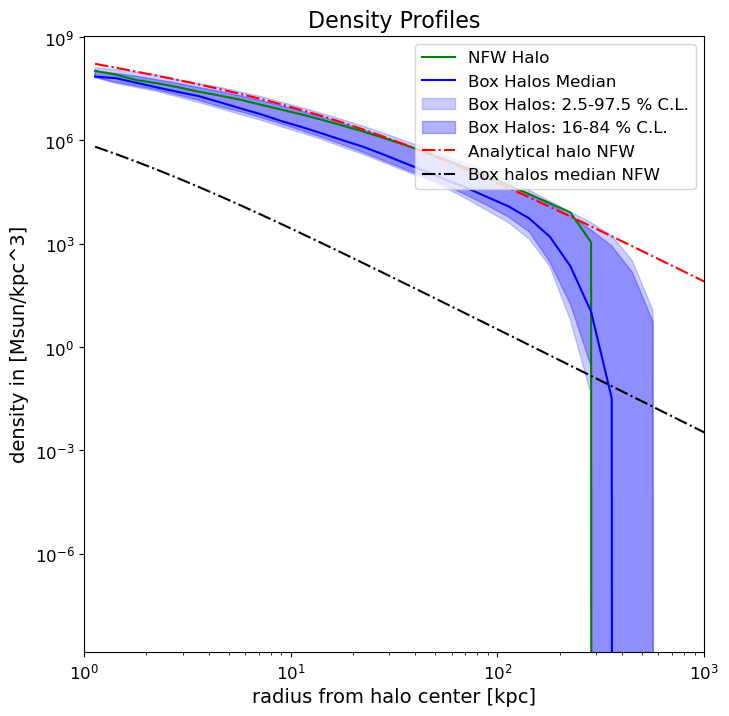

In [1]:
from shared.preface import *
from shared.shared_functions import *

class analyze_simulation_outputs(object):

    def __init__(self, sim_dir, objects):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if 'NFW_halo' in self.objects:

            batch_paths = glob.glob(
                f'{sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
            )
            
            self.vectors_benchmark = []
            for batch_path in batch_paths:
                self.vectors_benchmark.append(np.load(batch_path))
            self.vectors_benchmark = np.squeeze(
                np.array(self.vectors_benchmark)
            )
            self.vectors_benchmark = np.array(self.vectors_benchmark)

            self.etas_benchmark = np.load(
                f'{sim_dir}/number_densities_numerical_benchmark_halo.npy'
            )/N0


        if 'box_halos' in self.objects:
            
            self.etas_numerical = []
            self.vectors_numerical = []

            halo_num = len(np.load(
                glob.glob(f'{sim_dir}/halo*params.npy')[0]
            ))

            for halo in range(1, halo_num+1): 
                
                # Find all batch paths belonging to current halo.
                batch_paths = glob.glob(
                    f'{sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                )

                # Concatenate all vector batches into one array.
                vectors_halo = []
                for batch_path in batch_paths:
                    vectors_halo.append(np.load(batch_path))
                vectors_halo = np.squeeze(np.array(vectors_halo))

                # Append vectors.
                self.vectors_numerical.append(vectors_halo)

                # Append overdensities.
                self.etas_numerical.append(
                    np.load(
                        f'{sim_dir}/number_densities_numerical_halo{halo}.npy'
                    )/N0
                )

            self.etas_numerical = np.array(self.etas_numerical)
            self.vectors_numerical = np.array(self.vectors_numerical)


        if 'analytical_halo' in self.objects:

            batch_paths = glob.glob(
                f'{sim_dir}/neutrino_vectors_analytical_batch*.npy'
            )
            
            self.vectors_analytical = []
            for batch_path in batch_paths:
                self.vectors_analytical.append(np.load(batch_path))
            self.vectors_analytical = np.squeeze(
                np.array(self.vectors_analytical)
            )
            self.vectors_analytical = np.array(self.vectors_analytical)

            self.etas_analytical = np.load(
                f'{sim_dir}/number_densities_analytical.npy'
            )/N0


    def plot_overdensity_band(self, plot_ylims:tuple):

        ### ------------- ###
        ### Setup figure. ###
        ### ------------- ###
        fig, ax = plt.subplots(1,1)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Overdensity band')
        ax.set_xlabel(r'$m_{\nu}$ [meV]')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        ax.set_ylim(plot_ylims[0], plot_ylims[1])
        plt.grid(True, which="both", ls="-")

        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ------------- ###
        ### Plot objects. ###
        ### ------------- ###

        if 'NFW_halo' in self.objects:

            plt.plot(
                self.mrange*1e3, self.etas_benchmark-1, 
                color='green', label='(Benchmark) NFW Halo'
            )

        if 'box_halos' in self.objects:

            etas_median = np.median(
                self.etas_numerical, axis=0)
            etas_perc2p5 = np.percentile(
                self.etas_numerical, q=2.5, axis=0)
            etas_perc97p5 = np.percentile(
                self.etas_numerical, q=97.5, axis=0)
            etas_perc16 = np.percentile(
                self.etas_numerical, q=16, axis=0)
            etas_perc84 = np.percentile(
                self.etas_numerical, q=84, axis=0)
            
            ax.plot(
                self.mrange*1e3, (etas_median-1), color='blue', 
                label='Box Halos: medians'
            )
            ax.fill_between(
                self.mrange*1e3, (etas_perc2p5-1), (etas_perc97p5-1), 
                color='blue', alpha=0.2, label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                self.mrange*1e3, (etas_perc16-1), (etas_perc84-1), 
                color='blue', alpha=0.3, label='Box Halos: 16-84 % C.L.'
            )

        if 'analytical_halo' in self.objects:

            plt.plot(
                self.mrange*1e3, self.etas_analytical-1, 
                color='red', ls='solid', label='Analytical Halo'
            )

            # Plot endpoint values from Mertsch et al (2020).
            x_ends = [1e1, 3*1e2]
            y_ends = [3*1e-3, 4]
            ax.scatter(x_ends, y_ends, marker='x', s=15, color='orange')


        plt.legend(loc='lower right')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        plt.savefig(f'{self.fig_dir}/overdensity_band.pdf', **savefig_args)
        plt.close()


    def plot_overdensity_evolution(self, plot_ylims:tuple):

        ### ============= ###
        ### Setup figure. ###
        ### ============= ###

        fig, ax = plt.subplots(1,1, figsize=(8,12))
        ax.set_title('Overdensities (redshift) evolution')
        ax.set_xlabel('z')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        ax.set_yscale('log')
        ax.set_ylim(plot_ylims[0], plot_ylims[1])
        
        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ============= ###
        ### Plot objects. ###
        ### ============= ###

        z_int_steps = np.load(f'{sim_dir}/z_int_steps.npy')
        colors = ['blue', 'orange', 'green', 'red']


        ### ---------------- ###
        ### Analytical halo. ###
        ### ---------------- ###

        # Convert velocities to mementa.
        p_arr_ana, _ = velocity_to_momentum(
            self.vectors_analytical[...,3:6], self.mpicks
        )

        # Overdensities for each redshift as if it was the last in the sim.
        inds = np.arange(p_arr_ana.shape[-1])
        etas_ana_zeds = np.array(
            [
                number_density(p_arr_ana[...,0], p_arr_ana[...,z]) 
                for z in inds
            ]
        ).T/N0

        for j, m in enumerate(self.mpicks):
            ax.plot(
                z_int_steps, etas_ana_zeds[j]-1, 
                c=colors[j], ls='dashed', 
                label=f'Analytical Halo: {m:.3f} eV'
            )


        ### ---------------------- ###
        ### Box (numerical) halos. ###
        ### ---------------------- ###

        etas_num_zeds = []
        halo_num = len(self.vectors_numerical)
        for halo_j in range(halo_num):

            p_arr_num, _ = velocity_to_momentum(
                self.vectors_numerical[halo_j,...,3:6], self.mpicks
            )

            inds = np.arange(p_arr_num.shape[-1])
            etas_num_zeds.append(
                np.array(
                    [
                        number_density(p_arr_num[...,0], p_arr_num[...,z]) 
                        for z in inds
                    ]
                ).T/N0
            )
        etas_num_zeds = np.array(etas_num_zeds)

        etas_median = np.median(etas_num_zeds, axis=0)
        etas_perc2p5 = np.percentile(etas_num_zeds, q=2.5, axis=0)
        etas_perc97p5 = np.percentile(etas_num_zeds, q=97.5, axis=0)
        etas_perc16 = np.percentile(etas_num_zeds, q=16, axis=0)
        etas_perc84 = np.percentile(etas_num_zeds, q=84, axis=0)

        for j, m in enumerate(self.mpicks):
            ax.plot(
                z_int_steps, etas_median[j]-1, 
                color=colors[j], 
                label=f'{m:.3f} eV'
            )
            ax.fill_between(
                z_int_steps, (etas_perc2p5[j]-1), (etas_perc97p5[j]-1),
                color=colors[j], alpha=0.2, 
                label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                z_int_steps, (etas_perc16[j]-1), (etas_perc84[j]-1),
                color=colors[j], alpha=0.3, 
                label='Box Halos: 16-84 % C.L.'
            )


        # Invert ordering of items in legend (looks better since the curves 
        # of higher masses are higher up in the plot).
        handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles[::-1], labels[::-1], loc='lower right')

        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        plt.savefig(
            f'{self.fig_dir}/overdensity_evolution.pdf', **savefig_args
        )
        plt.close()


    def plot_phase_space(self, most_likely:bool):

        # Load necessary box and sim info.
        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        p_num = sim_setup['momentum_num']
        p_start = sim_setup['momentum_start']
        p_stop = sim_setup['momentum_stop']
        phis = sim_setup['phis']
        thetas = sim_setup['thetas']

        init_dis = sim_setup['initial_haloGC_distance']
        xE = np.cos(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
        yE = np.sin(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
        zE = np.cos(np.deg2rad(Pi))*init_dis
        init_xyz = np.array([xE, yE, zE])*kpc

        ### ---------------- ###
        ### Analytical halo. ###
        ### ---------------- ###


        # Convert velocities to mementa.
        vels_in = self.vectors_analytical[...,3:6]
        p_arr, y_arr = velocity_to_momentum(vels_in, self.mpicks)
        p0_arr, p1_arr, y0_arr = p_arr[...,0], p_arr[...,-1], y_arr[...,0]

        # Sort.
        ind = p0_arr.argsort(axis=-1)
        p1_sort = np.take_along_axis(p1_arr, ind, axis=-1)
        y0_sort = np.take_along_axis(y0_arr, ind, axis=-1)

        if most_likely:
            # Each velocity has a batch of neutrinos.
            # (min. of each to represent most (likely) clustered ones)
            m_len = (len(self.mpicks))
            p1_blocks = p1_sort.reshape((m_len, p_num, phis*thetas))
            p1_final = np.min(p1_blocks, axis=-1)
            y0_blocks = y0_sort.reshape((m_len, p_num, phis*thetas))
            y0_final = y0_blocks[...,0]
        else:
            p1_final = p1_sort
            y0_final = y0_sort

        # Fermi Dirac of the final momenta.
        FDvals = Fermi_Dirac(p1_final)

        fig, axs = plt.subplots(2,2, figsize=(12,12))
        fig.suptitle(
            'Phase-space distr. "today" compared to Fermi-Dirac' ,
            fontsize=18
        )

        savefig_args = dict(
            bbox_inches='tight'
        )

        for j, m_nu in enumerate(self.mpicks):

            k = j
            i = 0
            if j in (2,3):
                i = 1
                j -= 2

            # Simulation phase-space distr. of neutrinos today.
            axs[i,j].loglog(
                y0_final[k], FDvals[k], label='PS today (from sim)', c='red', alpha=0.9
            )

            # Fermi-Dirac phase-space distr.
            pOG = np.geomspace(
                p_start*T_CNB, p_stop*T_CNB, FDvals.shape[-1])
            FDvalsOG = Fermi_Dirac(pOG)
            yOG = pOG/T_CNB
            axs[i,j].loglog(yOG, FDvalsOG, label='PS Fermi-Dirac', c='blue', alpha=0.7)

            # Escape momentum.
            _, y_esc = escape_momentum_analytical(
                x_i=init_xyz, z=0., 
                R_vir=Rvir_MW, R_s=Rs_MW, rho_0=rho0_MW, m_nu_eV=m_nu
            )
            axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

            # Plot styling.
            axs[i,j].set_title(f'{m_nu} eV')
            axs[i,j].set_ylabel('FD(p)')
            axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
            axs[i,j].legend(loc='lower left')
            axs[i,j].set_ylim(1e-5, 1e0)
            axs[i,j].set_xlim(p_start, 1e2)

        plt.savefig(
            f'{self.fig_dir}/phase_space_analytical.pdf', **savefig_args
        )
        plt.close()          


        ### ---------------------- ###
        ### Box (numerical) halos. ###
        ### ---------------------- ###

        '''
        for halo_j in range(5):
            vels_in = self.vectors_numerical[halo_j,...,3:6]

            # Convert velocities to mementa.
            p_arr, y_arr = velocity_to_momentum(
                vels_in, self.mpicks
            )
            p0_arr, p1_arr, y0_arr = p_arr[...,0], p_arr[...,-1], y_arr[...,0]

            # Sort.
            ind = p0_arr.argsort(axis=-1)
            p1_sort = np.take_along_axis(p1_arr, ind, axis=-1)
            y0_sort = np.take_along_axis(y0_arr, ind, axis=-1)

            if most_likely:
                # Each velocity has a batch of neutrinos.
                # (min. of each to represent most (likely) clustered ones)
                m_len = (len(self.mpicks))
                p1_blocks = p1_sort.reshape((m_len, p_num, phis*thetas))
                p1_final = np.min(p1_blocks, axis=-1)
                y0_blocks = y0_sort.reshape((m_len, p_num, phis*thetas))
                y0_final = y0_blocks[...,0]
            else:
                p1_final = p1_sort
                y0_final = y0_sort

            # Fermi Dirac of the final momenta.
            FDvals = Fermi_Dirac(p1_final)

            fig, axs = plt.subplots(2,2, figsize=(12,12))
            fig.suptitle(
                'Phase-space distr. "today" compared to Fermi-Dirac' ,
                fontsize=18
            )

            savefig_args = dict(
                bbox_inches='tight'
            )

            for j, m_nu in enumerate(self.mpicks):

                k = j
                i = 0
                if j in (2,3):
                    i = 1
                    j -= 2

                # Simulation phase-space distr. of neutrinos today.
                axs[i,j].loglog(
                    y0_final[k], FDvals[k], label='PS today (from sim)', c='red', alpha=0.9
                )

                # Fermi-Dirac phase-space distr.
                pOG = np.geomspace(
                    p_start*T_CNB, p_stop*T_CNB, FDvals.shape[-1])
                FDvalsOG = Fermi_Dirac(pOG)
                yOG = pOG/T_CNB
                axs[i,j].loglog(yOG, FDvalsOG, label='PS Fermi-Dirac', c='blue', alpha=0.7)

                # Escape momentum.
                Rvir_halo = halo_param_arr[0]*kpc
                Mvir_halo = 10**(halo_param_arr[1])*Msun
                cNFW_halo = halo_param_arr[2]
                rho0_halo = scale_density_NFW(0., cNFW_halo)*(Msun/kpc**3)
                rs_halo = Rvir_halo/cNFW_halo
                _, y_esc = escape_momentum(
                    FCT_init_xys, 0., 
                    rho0_halo, Mvir_halo, Rvir_halo, rs_halo, m_nu, 'none'
                )
                axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

                # Plot styling.
                axs[i,j].set_title(f'{m_nu} eV')
                axs[i,j].set_ylabel('FD(p)')
                axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
                axs[i,j].legend(loc='lower left')
                axs[i,j].set_ylim(1e-5, 1e0)
                axs[i,j].set_xlim(p_start, 1e2)

            plt.savefig(
                f'{self.fig_dir}/phase_space_analytical.pdf', **savefig_args
            )
            plt.close()          
        '''


    def plot_density_profiles(
        self, mass_gauge, mass_range, NFW_orig=False
    ):

        ### ============= ###
        ### Setup figure. ###
        ### ============= ###

        fig, ax = plt.subplots(1,1)
        ax.set_title('Density Profiles')
        ax.set_xlabel('radius from halo center [kpc]')
        ax.set_ylabel('density in [Msun/kpc^3]')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(1e0, 1e3)
        # ax.set_ylim(1e1, 1e9)
        
        savefig_args = dict(
            bbox_inches='tight'
        )


        ### ============= ###
        ### Plot objects. ###
        ### ============= ###

        # Box and sim parameters.
        with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
            box_setup = yaml.safe_load(file)

        DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
        nums_snaps = np.load(f'{self.sim_dir}/nums_snaps.npy')

        # File Paths.
        box_file_dir = box_setup['File Paths']['Box File Directory']
        sim_parent = str(pathlib.Path(self.sim_dir).parent)
        benchmark_file_dir = f'{sim_parent}/benchmark_halo_files'

        # Box Cosmology.
        box_H0 =  box_setup['Cosmology']['h']*100*km/s/Mpc
        box_Omega_M = box_setup['Cosmology']['Omega_M']
        box_Omega_L = box_setup['Cosmology']['Omega_L']

        # Box halo sample arrays.
        hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
        halo_batch_IDs = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_indices.npy'
        )
        halo_batch_params = np.load(
            f'{self.sim_dir}/halo_batch_{hname}_params.npy'
        )

        # Bin centers in kpc.
        radial_bins = 10**np.arange(0, 5, 0.1)
        centers = bin_centers(radial_bins)

        if 'NFW_halo' in objects:

            NFW_halo_coords = np.load(
                f'{benchmark_file_dir}/benchmark_halo_snap_{nums_snaps[-1]}.npy'
            )

            # Calculate density for each bin center.
            NFW_halo_densities = analyse_halo(DM_mass/Msun, NFW_halo_coords)
            
            ax.plot(
                centers, NFW_halo_densities, 
                    c='green', label=f'NFW Halo'
            )

        if 'box_halos' in objects:

            densities = []
            for halo_ID in halo_batch_IDs:

                # Read the DM positions of all halos at redshift z=0.
                DM_coords, _ = read_DM_halo_index(
                    snap=nums_snaps[-1], halo_ID=halo_ID,
                    fname='', sim_dir=box_file_dir, out_dir='', direct=True
                )
                # Calculate density for each bin center.
                densities.append(analyse_halo(DM_mass/Msun, DM_coords))

            densities = np.array(densities)
            densities_median = np.median(densities, axis=0)
            densities_perc2p5 = np.percentile(densities, q=2.5, axis=0)
            densities_perc97p5 = np.percentile(densities, q=97.5, axis=0)
            densities_perc16 = np.percentile(densities, q=16, axis=0)
            densities_perc84 = np.percentile(densities, q=84, axis=0)

            ax.plot(
                centers, densities_median, 
                c='blue', label=f'Box Halos Median'
            )
            ax.fill_between(
                centers, densities_perc2p5, densities_perc97p5,
                color='blue', alpha=0.2, 
                label='Box Halos: 2.5-97.5 % C.L.'
            )
            ax.fill_between(
                centers, densities_perc16, densities_perc84,
                color='blue', alpha=0.3, 
                label='Box Halos: 16-84 % C.L.'
            )


        if 'analytical_halo' in objects:

            NFW = NFW_profile(
                centers*kpc, rho0_MW, Rs_MW
            )
            ax.plot(
                centers, NFW/(Msun/kpc**3), 
                c='red', ls='-.', label='Analytical halo NFW'
            )


        if NFW_orig:

            # NFW density profile with parameters of sampled halo.
            box_halos_R200_median = np.median(halo_batch_params[:,2])
            box_halos_c200_median = np.median(halo_batch_params[:,2])
            box_halos_Rs_median = box_halos_R200_median/box_halos_c200_median
            rho_NFW = scale_density_NFW(
                c=box_halos_c200_median, z=0.,
                 H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L
            )
            NFW = NFW_profile(
                centers*kpc, rho_NFW, box_halos_Rs_median*kpc
            )
            ax.plot(
                centers, NFW/(Msun/kpc**3), 
                c='black', ls='-.', label='Box halos median NFW'
            )

        plt.legend(loc='lower left')
        plt.savefig(
            f'{self.fig_dir}/density_profiles_subset.pdf', **savefig_args
        )
        plt.show()
        plt.close()


### Specify simulation directory and objects therein to analyze.
sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'
objects = (
    'NFW_halo', 
    'box_halos', 
    'analytical_halo'
)

### Initialize the class, which has all simulation outputs and plotting scripts.
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
)

### Generate plots. Output in figures/{sim_dir}.
# Analysis.plot_overdensity_band(plot_ylims=(3*1e-4,1e1))
# Analysis.plot_overdensity_evolution(plot_ylims=(1e-4,1e1))
# Analysis.plot_phase_space(most_likely=True)
Analysis.plot_density_profiles(mass_gauge=12.0, mass_range=0.6, NFW_orig=True)